<a href="https://colab.research.google.com/github/azizfath/bdpa_lanjut/blob/master/Final_Project_Big_Data_Lanjut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Email Spam Classification with TF-IDF Algorithm and Naive Bayes Classfication using Pyspark**

###Members of the group:


* FATHURRAHMAN NUR AZIZ (20.11.3694)
* MUHAMMAD BASTIAN HANAFI (20.11.3714)
* MIFTAHUDIN FAIZ         (20.11.3675)



##1. Import Library and Modules

In [1]:
#installing findspark and pyspark
!pip install -q findspark
!pip install -q pyspark

In [2]:
import pandas as pd
from pyspark.sql import SparkSession

#preprocessing lib
from pyspark.sql.functions import length,split,when,regexp_replace,col,trim,lower

#TF-IDF lib
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF, StringIndexer, VectorAssembler
from pyspark.ml.linalg import Vector

#Naive Bayes
from pyspark.ml.classification import NaiveBayes
from pyspark.ml import Pipeline

#model evaluation lib
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
#creating spark session
spark = SparkSession.builder.appName('final project').getOrCreate()

##2. Load Dataset

In [4]:
#DATASET 1 : https://www.kaggle.com/datasets/studymart/spam-email-detection-dataset
#DATASET 2 : https://www.kaggle.com/datasets/nitishabharathi/email-spam-dataset
#DATASET 3 : https://www.kaggle.com/datasets/juanagsolano/spam-email-from-enron-dataset
#DATASET 4 : https://www.kaggle.com/datasets/abhishek14398/sms-spam-collection

path1 = '/content/drive/MyDrive/Colab Notebooks/BDPA LANJUT/FP/emails.csv'
path2 = '/content/drive/MyDrive/Colab Notebooks/BDPA LANJUT/FP/labeled_emails.csv'
path3 = '/content/drive/MyDrive/Colab Notebooks/BDPA LANJUT/FP/completeSpamAssassin.csv'
path4 = '/content/drive/MyDrive/Colab Notebooks/BDPA LANJUT/FP/SMSSpamCollection.csv'

In [5]:
#read csv for dataset 1 with spark
df1 = spark.read.csv(path1, header=True, inferSchema=True)

#read csv for dataset 2 with pandas then converted to spark
df2 = pd.read_csv(path2).astype(str)
df2 = spark.createDataFrame(df2)

#read csv for dataset 3 with pandas then converted to spark
df3 = pd.read_csv(path3).astype(str)
df3 = spark.createDataFrame(df3)

#read csv for dataset 4 with spark
df4 = spark.read.csv(path4)

##3. Data Preprocessing

#### Dataset 1


In [6]:
#visualize df1
df1.show(5)

+--------------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|                text|spam| _c2| _c3| _c4| _c5| _c6| _c7| _c8| _c9|_c10|_c11|_c12|_c13|_c14|_c15|_c16|_c17|_c18|_c19|_c20|_c21|_c22|_c23|_c24|_c25|_c26|_c27|_c28|_c29|_c30|_c31|_c32|_c33|_c34|_c35|_c36|_c37|_c38|_c39|_c40|_c41|_c42|_c43|_c44|_c45|_c46|_c47|_c48|_c49|_c50|_c51|_c52|_c53|_c54|_c55|_c56|_c57|_c58|_c59|_c60|_c61|_c62|_c63|_c64|_c65|_c66|_c67|_c68|_c69|_c70|_c71|_c72|_c73|_c74|_c75|_c76|_c77|_c78|_c79|_c80|

In [7]:
#selecting column and removing the word "Subject: " and "re : " that not usable
df1 = df1.select(regexp_replace(df1['text'], 'Subject: ', '').alias('text'),'spam')
df1 = df1.select(regexp_replace(df1['text'], 're : ', '').alias('text'),'spam')

#visualize df1 after clearing data
df1.show(5)

#print schema of df1
df1.printSchema()

+--------------------+----+
|                text|spam|
+--------------------+----+
|naturally irresis...|   1|
|the stock trading...|   1|
|unbelievable new ...|   1|
|4 color printing ...|   1|
|do not have money...|   1|
+--------------------+----+
only showing top 5 rows

root
 |-- text: string (nullable = true)
 |-- spam: string (nullable = true)



In [8]:
#converting "spam" column to integer
df1 = df1.withColumn('spam', when(df1['spam'] == '0',0) \
                             .otherwise(when(df1['spam'] == '1',1)))

#print schema of df1
df1.printSchema()

root
 |-- text: string (nullable = true)
 |-- spam: integer (nullable = true)



In [9]:
#count null values from dataframe
print("Null Count from Text: ", df1.filter(col("text").isNull()).count())
print("Null Count from Spam: ", df1.filter(col("spam").isNull()).count())

Null Count from Text:  0
Null Count from Spam:  1536


In [10]:
#drop the row that contain null value
df1 = df1.na.drop()

#count null values from dataframe
print("Null Count from Text: ", df1.filter(col("text").isNull()).count())
print("Null Count from Spam: ", df1.filter(col("spam").isNull()).count())

Null Count from Text:  0
Null Count from Spam:  0


In [11]:
#visualize df1 after all kind of preprocessing
df1.show(5)

+--------------------+----+
|                text|spam|
+--------------------+----+
|naturally irresis...|   1|
|the stock trading...|   1|
|unbelievable new ...|   1|
|4 color printing ...|   1|
|do not have money...|   1|
+--------------------+----+
only showing top 5 rows



#### Dataset 2


In [12]:
#visualize df2
df2.show(5)

#print schema of df2
df2.printSchema()

+--------------------+-----+
|               email|label|
+--------------------+-----+
|Subject: re : ran...|  ham|
|Subject: re : vis...|  ham|
|Subject: research...|  ham|
|Subject: christma...|  ham|
|Subject: japan ca...|  ham|
+--------------------+-----+
only showing top 5 rows

root
 |-- email: string (nullable = true)
 |-- label: string (nullable = true)



In [13]:
#remove some endline and indent character from "email" and convert "label" to integer
df2 = df2.withColumn('text', regexp_replace(df2['email'], '[\n\t]', ''))\
         .withColumn('spam', when(df2['label'] == 'ham',0 ) \
                             .otherwise(when(df2['label'] == 'spam', 1))) \
         .drop('email','label')

#print schema of df2
df2.printSchema()

root
 |-- text: string (nullable = true)
 |-- spam: integer (nullable = true)



In [14]:
#removing the word "Subject: " and "re : " that not usable
df2 = df2.select(regexp_replace(df2['text'], 'Subject: ', '').alias('text'),'spam')
df2 = df2.select(regexp_replace(df2['text'], 're : ', '').alias('text'),'spam')

In [15]:
#count null values from dataframe
print("Null Count from Text: ", df2.filter(col("text").isNull()).count())
print("Null Count from Spam: ", df2.filter(col("spam").isNull()).count())

Null Count from Text:  0
Null Count from Spam:  0


In [16]:
#visualize df2 after all kind of preprocessing
df2.show(5)

+--------------------+----+
|                text|spam|
+--------------------+----+
| rankingsthank you .|   0|
|visit to enronvin...|   0|
|research group mo...|   0|
|christmas baskets...|   0|
|japan candidatevi...|   0|
+--------------------+----+
only showing top 5 rows



#### Dataset 3


In [17]:
#visualize df3
df3.show(5)

#print schema of df3
df3.printSchema()

+----------+--------------------+-----+
|Unnamed: 0|                Body|Label|
+----------+--------------------+-----+
|         0|\nSave up to 70% ...|    1|
|         1|1) Fight The Risk...|    1|
|         2|1) Fight The Risk...|    1|
|         3|#################...|    1|
|         4|I thought you mig...|    1|
+----------+--------------------+-----+
only showing top 5 rows

root
 |-- Unnamed: 0: string (nullable = true)
 |-- Body: string (nullable = true)
 |-- Label: string (nullable = true)



In [18]:
#remove some endline and indent character from "Body" and convert "Label" to integer
df3 = df3.withColumn('text', regexp_replace(df3['Body'], '[\n\t]', ''))\
         .withColumn('spam', when(df3['Label'] == '0',0) \
                             .otherwise(when(df3['Label'] == '1',1))) \
         .drop('Unnamed: 0','Body','Label')

#print schema of df3
df3.printSchema()

root
 |-- text: string (nullable = true)
 |-- spam: integer (nullable = true)



In [19]:
#count null values from dataframe
print("Null Count from Text: ", df3.filter(col("text").isNull()).count())
print("Null Count from Spam: ", df3.filter(col("spam").isNull()).count())

Null Count from Text:  0
Null Count from Spam:  0


In [20]:
#visualize df3 after all kind of preprocessing
df3.show(5)

+--------------------+----+
|                text|spam|
+--------------------+----+
|Save up to 70% on...|   1|
|1) Fight The Risk...|   1|
|1) Fight The Risk...|   1|
|#################...|   1|
|I thought you mig...|   1|
+--------------------+----+
only showing top 5 rows



#### Dataset 4


In [21]:
#visualize df4
df4.show(5)

#print schema of df4
df4.printSchema()

+--------------------+
|                 _c0|
+--------------------+
|ham\tGo until jur...|
|ham\tOk lar... Jo...|
|spam\tFree entry ...|
|ham\tU dun say so...|
|ham\tNah I don't ...|
+--------------------+
only showing top 5 rows

root
 |-- _c0: string (nullable = true)



In [22]:
#split column into 2 column, separated by "\t"
df4 = df4.withColumn('text', split(df4['_c0'], '\t').getItem(1)) \
         .withColumn('class', split(df4['_c0'], '\t').getItem(0)) \
         .drop('_c0')

#visualize df4
df4.show(5)

+--------------------+-----+
|                text|class|
+--------------------+-----+
|Go until jurong p...|  ham|
|Ok lar... Joking ...|  ham|
|Free entry in 2 a...| spam|
|U dun say so earl...|  ham|
|Nah I don't think...|  ham|
+--------------------+-----+
only showing top 5 rows



In [23]:
#converting "class" into integer
df4 = df4.withColumn('spam', when(df4['class'] == 'ham',0) \
                             .otherwise(when(df4['class'] == 'spam',1))) \
         .drop('class')

#print schema of df4
df3.printSchema()

root
 |-- text: string (nullable = true)
 |-- spam: integer (nullable = true)



In [24]:
#count null values from dataframe
print("Null Count from Text: ", df4.filter(col("text").isNull()).count())
print("Null Count from Spam: ", df4.filter(col("spam").isNull()).count())

Null Count from Text:  0
Null Count from Spam:  143


In [25]:
#drop the row that contain null value
df4 = df4.na.drop()

#count null values from dataframe
print("Null Count from Text: ", df4.filter(col("text").isNull()).count())
print("Null Count from Spam: ", df4.filter(col("spam").isNull()).count())

Null Count from Text:  0
Null Count from Spam:  0


In [26]:
#visualize df4 after all kind of preprocessing
df4.show(5)

+--------------------+----+
|                text|spam|
+--------------------+----+
|Go until jurong p...|   0|
|Ok lar... Joking ...|   0|
|Free entry in 2 a...|   1|
|U dun say so earl...|   0|
|Nah I don't think...|   0|
+--------------------+----+
only showing top 5 rows



####Combining 4 dataset

In [27]:
#appending all dataset into single dataset
df = df1.union(df2)\
        .union(df3)\
        .union(df4)

#print total rows
print(f'Total Rows: {df.count()}')

#visualise the dataset
df.show(5)

Total Rows: 21525
+--------------------+----+
|                text|spam|
+--------------------+----+
|naturally irresis...|   1|
|the stock trading...|   1|
|unbelievable new ...|   1|
|4 color printing ...|   1|
|do not have money...|   1|
+--------------------+----+
only showing top 5 rows



In [28]:
#create function to remove punctuation
def removePunctuation(column):
     return trim(lower(regexp_replace(column,'[^\sa-zA-Z0-9]', ''))).alias('text')

In [29]:
#removing punctuation from "text" column
df = df.select(removePunctuation("text"),"spam")

In [30]:
#visualize the dataset
df.show()

+--------------------+----+
|                text|spam|
+--------------------+----+
|naturally irresis...|   1|
|the stock trading...|   1|
|unbelievable new ...|   1|
|4 color printing ...|   1|
|do not have money...|   1|
|great nnews  hell...|   1|
|save your money b...|   1|
|undeliverable  ho...|   1|
|save your money b...|   1|
|las vegas high ri...|   1|
|save your money b...|   1|
|brighten those te...|   1|
|fpa notice  ebay ...|   1|
|search engine pos...|   1|
|only our software...|   1|
|localized softwar...|   1|
|security alert  c...|   1|
|21 st century web...|   1|
|any med for your ...|   1|
|wearable electron...|   1|
+--------------------+----+
only showing top 20 rows



In [31]:
#add length into dataset based on "text" length
data = df.withColumn('length',length(df['text']))

#visualize the dataset
data.show(5)

+--------------------+----+------+
|                text|spam|length|
+--------------------+----+------+
|naturally irresis...|   1|  1285|
|the stock trading...|   1|   588|
|unbelievable new ...|   1|   432|
|4 color printing ...|   1|   465|
|do not have money...|   1|   213|
+--------------------+----+------+
only showing top 5 rows



In [32]:
#observe spam class
data.groupby('spam').mean().show()

+----+---------+-----------------+
|spam|avg(spam)|      avg(length)|
+----+---------+-----------------+
|   1|      1.0|1155.201204592509|
|   0|      0.0|998.4447939797681|
+----+---------+-----------------+



##4. Feature Transformations

In [33]:
#tokenizing word from "text" column
tokenizer = Tokenizer(inputCol="text", outputCol="token_text")

#removing stopword
stopremove = StopWordsRemover(inputCol='token_text',outputCol='stop_tokens')

#implement TF-IDF
count_vec = CountVectorizer(inputCol='stop_tokens',outputCol='c_vec')
idf = IDF(inputCol="c_vec", outputCol="tf_idf")
ham_spam_to_num = StringIndexer(inputCol='spam',outputCol='label')
clean_up = VectorAssembler(inputCols=['tf_idf','length'],outputCol='features')

##5. Creating Model and Pipeline

In [34]:
#Create Naive Bayes Classification Models
nb = NaiveBayes()

In [35]:
#creating pipeline params
data_prep_pipe = Pipeline(stages=[ham_spam_to_num,tokenizer,stopremove,count_vec,idf,clean_up])

#fitting data into pipeline
cleaner = data_prep_pipe.fit(data)

#transform and clean data
clean_data = cleaner.transform(data)

##6. Training and Testing

In [36]:
#selecting label and features from data transformation
clean_data = clean_data.select(['label','features'])
clean_data.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  1.0|(182122,[0,23,31,...|
|  1.0|(182122,[0,15,22,...|
|  1.0|(182122,[0,9,13,1...|
|  1.0|(182122,[0,8,23,3...|
|  1.0|(182122,[0,11,54,...|
|  1.0|(182122,[0,10,40,...|
|  1.0|(182122,[0,11,15,...|
|  1.0|(182122,[0,8,16,2...|
|  1.0|(182122,[0,11,15,...|
|  1.0|(182122,[0,5,8,10...|
|  1.0|(182122,[0,11,15,...|
|  1.0|(182122,[0,6,11,1...|
|  1.0|(182122,[0,5,9,19...|
|  1.0|(182122,[0,5,6,8,...|
|  1.0|(182122,[0,87,92,...|
|  1.0|(182122,[0,15,18,...|
|  1.0|(182122,[0,23,108...|
|  1.0|(182122,[0,5,8,16...|
|  1.0|(182122,[0,54,72,...|
|  1.0|(182122,[0,8,25,3...|
+-----+--------------------+
only showing top 20 rows



In [37]:
#spliting data training and data testing with 85:25 split
(X,y) = clean_data.randomSplit([0.85,0.25])

#train Naive bayes Classification with data training
train = nb.fit(X)

#try to predict
pred = train.transform(y)
pred.show()

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|(182122,[0,1,2,3,...|[-15444.770356405...|           [1.0,0.0]|       0.0|
|  0.0|(182122,[0,1,2,3,...|[-2602.9540763123...|[1.0,3.8300899826...|       0.0|
|  0.0|(182122,[0,1,2,3,...|[-20304.790193378...|           [1.0,0.0]|       0.0|
|  0.0|(182122,[0,1,2,3,...|[-13956.155346965...|           [1.0,0.0]|       0.0|
|  0.0|(182122,[0,1,2,3,...|[-9386.8406608351...|           [1.0,0.0]|       0.0|
|  0.0|(182122,[0,1,2,3,...|[-9396.7247629405...|           [1.0,0.0]|       0.0|
|  0.0|(182122,[0,1,2,3,...|[-5118.7382284580...|           [1.0,0.0]|       0.0|
|  0.0|(182122,[0,1,2,3,...|[-4224.8280978355...|           [1.0,0.0]|       0.0|
|  0.0|(182122,[0,1,2,3,...|[-13714.583631795...|           [1.0,0.0]|       0.0|
|  0.0|(182122,[

##7. Model Evaluation

In [38]:
#evaluate classification to show accuracy
eval = MulticlassClassificationEvaluator()
accuracy = eval.evaluate(pred)
print(f'Accuracy of model at spam classification : {str(accuracy)}')

Accuracy of model at spam classification : 0.9284203939957699


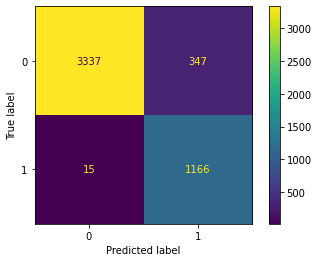

In [39]:
#show confusion matrix
y_pred=pred.select("prediction").collect()
y_orig=pred.select("label").collect()
cm = confusion_matrix(y_orig, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

##Analytics: 
Based on the Confusion Matrix, the classification produces:

* True Negative : 3337
* True Positive : 1166
* False Positive : 347
* False Negative : 15

**So it can be said that the classification can actually make spam or ham predictions because there are very few false classification values**



**A fairly high accuracy score (92.84%) indicates that the classification of the dataset using Naive Bayes has produced a good class prediction so that it can perform a good spam classification**